In [1]:
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
import networkx as nx
import pandas as pd
import numpy as np
import itertools
import sys
sys.path.append("./GeneSNAKE")

import genesnake as gs
from methods.grn_inference import infer_networks

# Processing

In [ ]:
network = pd.read_csv("Ecoli-1_goldstandard_signed.tsv", sep="\t",header=None)
ss1 = pd.read_csv("Ecoli-1_wildtype.tsv", sep="\t")
ss2 = pd.read_csv("Ecoli-1_knockdowns.tsv", sep="\t")

gene_list = list(ss1.columns)
genes = len(gene_list)

network1 = pd.DataFrame(data = np.zeros((genes,genes)), index = gene_list, columns = gene_list)

for i in range(network.values.shape[0]):
    x = np.where(np.array(gene_list) == network.values[i,0])
    y = np.where(np.array(gene_list) == network.values[i,1])

    if network.values[i,2] == "+":
        network1.values[x,y] = 1
    elif network.values[i,2] == "-":
        network1.values[x,y] = -1

true_fc = np.zeros((genes,genes))
for i in range(genes):
    for j in range(genes):
        true_fc[i,j] = np.log2(ss2.values[i,j]/ss1.values[0][j])

FC = pd.DataFrame(data = true_fc, index = gene_list, columns = gene_list)

# Simulation

In [58]:
M = gs.GRNmodel.make_model(network1,combinations={"comb_prob":0.5, "max_comb":0})
M.set_pert("diag",effect=0.5,noise=0,multipert=3,exp=1,reps=1,sign=-1)
M.simulate_data(exp_type="ss",SNR=50,noise_model="normal", restart_control = True)

noise = M.noise
data = M.data
noise_free_data = M.noise_free_data
fold_change_data = np.zeros((genes,genes))
nsf_fold_change_data = np.zeros((genes,genes))

for i in range(genes):
    for j in range(genes):
        fold_change_data[j,i] = np.log2(M.data.values[j,i]/M.steady_state_RNA[j])
        nsf_fold_change_data[j,i] = np.log2(M.noise_free_data.values[j,i]/M.noise_free_steady_state_RNA[j])
fold_change_data = pd.DataFrame(fold_change_data,index=M.data.index,columns=M.data.columns)
nsf_fold_change_data = pd.DataFrame(nsf_fold_change_data,index=M.data.index,columns=M.data.columns)

['start_rna', 'start_prot', 'time', 'max_rna_exp', 'max_prot_exp', 'hill_coef', 'combinations', 'alphas', 'dis_const', 'lambda_RNA', 'lambda_prot']
hehehehehe
hehehehehe
va
hallo
ss1
mm2


# Inference and benchmark GNW data

In [73]:
pred = infer_networks(FC, M.perturbation,"lsco", zvec = np.logspace(-6,0,100))
A = network1
np.fill_diagonal(A.values,1)
nets = gs.benchmarking.cutoff_handler(pred, zvec_auto = True)

correct = gs.benchmarking.compare_networks(nets,A,exclude_diag=False)
print("AUPR GNW: ", correct["AUPR"])

AUPR GNW:  0.9412


# Inference and benchmark GS data from GNW network

In [72]:
pred = infer_networks(nsf_fold_change_data.T, M.perturbation,"lscon", zvec = np.logspace(-6,0,100)) #Using transpose of FC dataframe
A = network1
np.fill_diagonal(A.values,1)
nets = gs.benchmarking.cutoff_handler(pred, zvec_auto = True)

correct = gs.benchmarking.compare_networks(nets,A,exclude_diag=False)
print("AUPR GS: ", correct["AUPR"])

AUPR GS:  0.9412


# Data comparison

Text(0.5, 1.0, 'GS')

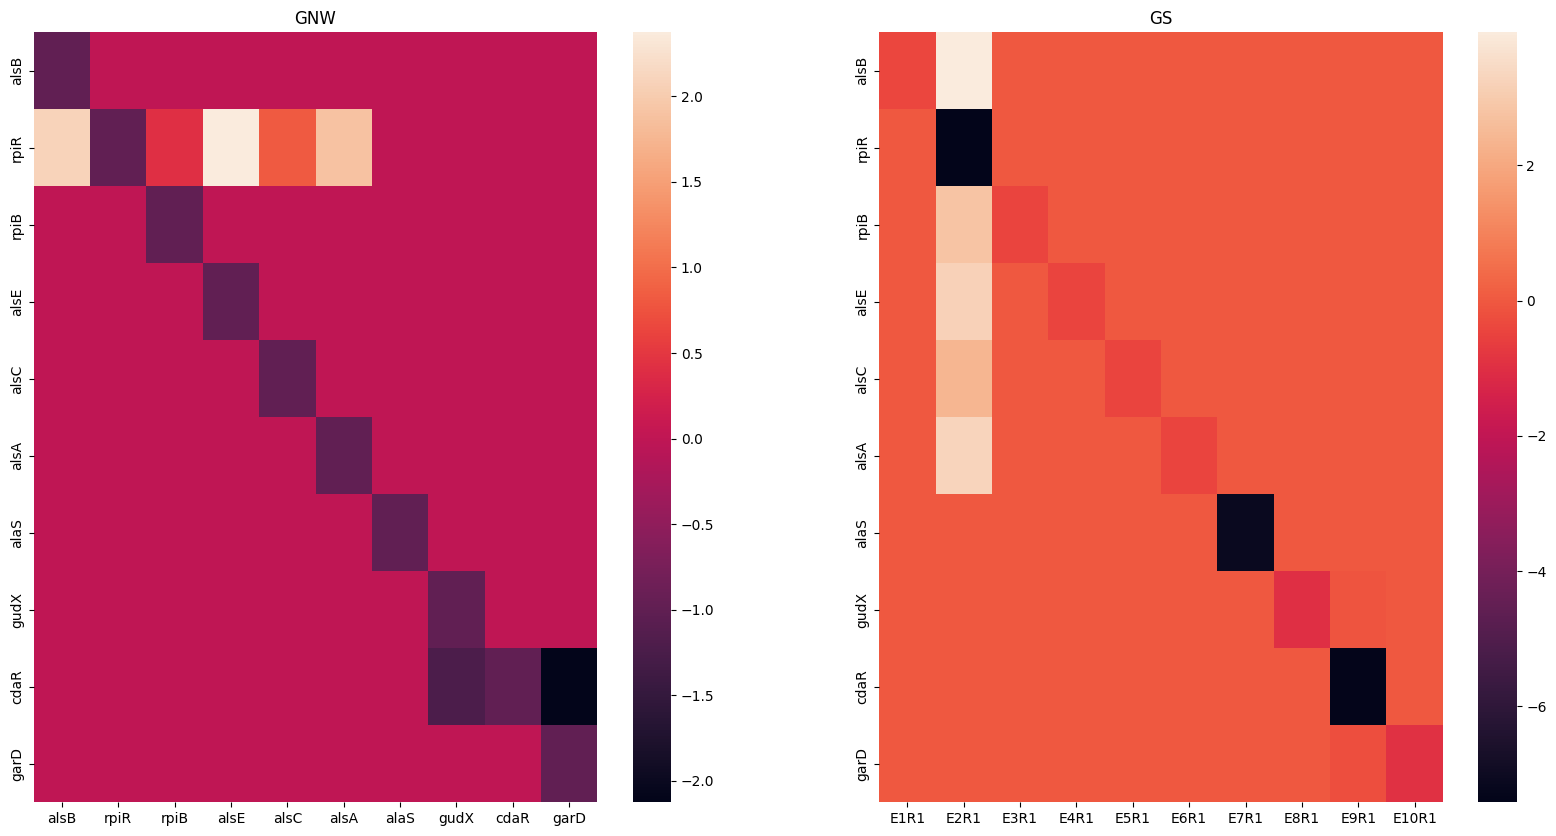

In [70]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
sns.heatmap(FC, ax=ax1)
ax1.set_title('GNW')
sns.heatmap(nsf_fold_change_data, ax=ax2)
ax2.set_title("GS")